# 10 — Extended Training: 50 Epochs, 4 Konfigurasi

Pelatihan extended (50 epoch, patience=10) untuk 4 konfigurasi:

| # | Model | Data | Train Size | Val Size | Epochs |
|---|-------|------|-----------|---------|--------|
| 1 | Multi-Task (Wang et al., 2021) | Original | 2,083 | 368 | P1=3 + P2=47 |
| 2 | Multi-Task (Wang et al., 2021) | Augmented | 4,290 | 368 | P1=3 + P2=47 |
| 3 | Single-Task (IndoBERT + CRF) | Original | 2,083 | 368 | 50 |
| 4 | Single-Task (IndoBERT + CRF) | Augmented | 4,290 | 368 | 50 |

**Hyperparameters** (best config dari NB03, F1=0.7410):
- Model: `indobenchmark/indobert-large-p2`
- λ1=0.3, λ2=0.3, Dropout=0.1, Weight Decay=0.01
- No layer freezing, LR BERT=2e-5, LR Head=1e-4
- Batch=4, Grad Accum=4 (eff=16), Warmup=0.1, Max Grad Norm=1.0
- Patience=10 (semua run)

**Referensi hasil sebelumnya:**

| Model | F1 |
|---|---|
| Penelitian sebelumnya (EMC-GCN) | 0.6761 |
| Multi-task NB03 (18 ep) | 0.7410 |
| Single-task NB07 (18 ep) | 0.7551 |
| Multi-seed mean MT (NB09) | 0.7319 ± 0.0067 |
| Multi-seed mean ST (NB09) | 0.7297 ± 0.0166 |

In [1]:
import json
import os
import string
import time
import gc
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import (
    classification_report,
    f1_score as seq_f1_score,
    precision_score as seq_precision_score,
    recall_score as seq_recall_score,
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
AUG_TRAIN_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_augmented_train.json')
AUG_VAL_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_val.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training config
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4
NUM_EPOCHS = 50
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
DROPOUT = 0.1
IGNORE_INDEX = -100

# Multi-task specific
LAMBDA1 = 0.3
LAMBDA2 = 0.3
PHASE1_EPOCHS = 3
MAX_REL_POS = 20
PATIENCE = 10

# Seed
SEED = 42

# Reference
PRIOR_RESEARCH_F1 = 0.6761

# Run definitions
RUNS = [
    {'name': 'MT + Original',  'model_type': 'multi_task',  'data_type': 'original'},
    {'name': 'MT + Augmented', 'model_type': 'multi_task',  'data_type': 'augmented'},
    {'name': 'ST + Original',  'model_type': 'single_task', 'data_type': 'original'},
    {'name': 'ST + Augmented', 'model_type': 'single_task', 'data_type': 'augmented'},
]

print(f'Total runs: {len(RUNS)}')
print(f'Epochs per run: {NUM_EPOCHS} (patience={PATIENCE})')
print(f'Seed: {SEED}')
for i, r in enumerate(RUNS):
    print(f'  Run {i+1}: {r["name"]}')

Total runs: 4
Epochs per run: 50 (patience=10)
Seed: 42
  Run 1: MT + Original
  Run 2: MT + Augmented
  Run 3: ST + Original
  Run 4: ST + Augmented


### 2. LOAD DATA & TOKENIZER

In [3]:
# Original data (2,451 samples — will be split 85/15)
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

# Augmented pre-split data
with open(AUG_TRAIN_PATH, 'r', encoding='utf-8') as f:
    raw_aug_train = json.load(f)
with open(AUG_VAL_PATH, 'r', encoding='utf-8') as f:
    raw_aug_val = json.load(f)

# Lexicons
def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)
overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f'Original data: {len(raw_data)}')
print(f'Augmented train: {len(raw_aug_train)}')
print(f'Augmented val: {len(raw_aug_val)}')
print(f'Pos lexicon: {len(pos_lexicon)} | Neg lexicon: {len(neg_lexicon)}')

Original data: 2451
Augmented train: 4290
Augmented val: 368
Pos lexicon: 2288 | Neg lexicon: 5025


### 3. LABELS & DATA PREPARATION

In [4]:
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}


def _compute_word_prior(raw_data):
    """Compute word-level ATE prior probabilities from raw data."""
    word_ate_freq = {}
    for d in raw_data:
        for tok, lab in zip(d['tokens'], d['labels']):
            tok_lower = tok.lower()
            if tok_lower not in word_ate_freq:
                word_ate_freq[tok_lower] = [0] * len(ate_labels)
            if lab == 'O':
                word_ate_freq[tok_lower][ate_label2id['O']] += 1
            else:
                word_ate_freq[tok_lower][ate_label2id[lab.split('-')[0]]] += 1
    default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
    word_prior = {}
    for word, counts in word_ate_freq.items():
        total = sum(counts)
        word_prior[word] = [c / total for c in counts] if total > 0 else default_prior
    return word_prior, default_prior


def _tokenize_mt_samples(raw_data, tokenizer, word_prior, default_prior, pos_lexicon, neg_lexicon):
    """Tokenize and align labels for multi-task model."""
    all_input_ids, all_attention_mask = [], []
    all_ate, all_sld, all_asd, all_bieos, all_crf, all_prior = [], [], [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        ate_w, sld_w, asd_w = [], [], []
        for tok, lab in zip(tokens, labels):
            if lab == 'O':
                ate_w.append('O'); asd_w.append('O')
            else:
                prefix, sentiment = lab.split('-', 1)
                ate_w.append(prefix); asd_w.append(sentiment)
            t_clean = tok.lower().strip(string.punctuation)
            if t_clean in pos_lexicon:
                sld_w.append('POS')
            elif t_clean in neg_lexicon:
                sld_w.append('NEG')
            else:
                sld_w.append('O')

        ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0); prior_a.append(default_prior)
            elif wid != prev_wid:
                if wid < len(tokens):
                    ate_a.append(ate_label2id[ate_w[wid]])
                    sld_a.append(sld_label2id[sld_w[wid]])
                    asd_a.append(asd_label2id[asd_w[wid]])
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                    prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
                else:
                    ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                    asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                    crf_a.append(0); prior_a.append(default_prior)
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_ate.append(torch.tensor(ate_a, dtype=torch.long))
        all_sld.append(torch.tensor(sld_a, dtype=torch.long))
        all_asd.append(torch.tensor(asd_a, dtype=torch.long))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))
        all_prior.append(torch.tensor(prior_a, dtype=torch.float))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'ate_labels': torch.stack(all_ate),
        'sld_labels': torch.stack(all_sld),
        'asd_labels': torch.stack(all_asd),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
        'prior_probs': torch.stack(all_prior),
    }


def _tokenize_st_samples(raw_data, tokenizer):
    """Tokenize and align labels for single-task model."""
    all_input_ids, all_attention_mask, all_bieos, all_crf = [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        bieos_a, crf_a = [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            elif wid != prev_wid:
                if wid < len(tokens):
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                else:
                    bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            else:
                bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
    }


# --- Prepare all data upfront ---

# Original data (full 2451 — split by indices at training time)
print('Preparing original multi-task data...')
orig_word_prior, default_prior = _compute_word_prior(raw_data)
mt_orig_data = _tokenize_mt_samples(raw_data, tokenizer, orig_word_prior, default_prior, pos_lexicon, neg_lexicon)

print('Preparing original single-task data...')
st_orig_data = _tokenize_st_samples(raw_data, tokenizer)

# Augmented data (pre-split: train and val separately)
# Prior computed from augmented TRAIN only (no leakage)
print('Preparing augmented multi-task data...')
aug_word_prior, _ = _compute_word_prior(raw_aug_train)
mt_aug_train_data = _tokenize_mt_samples(raw_aug_train, tokenizer, aug_word_prior, default_prior, pos_lexicon, neg_lexicon)
mt_aug_val_data = _tokenize_mt_samples(raw_aug_val, tokenizer, aug_word_prior, default_prior, pos_lexicon, neg_lexicon)

print('Preparing augmented single-task data...')
st_aug_train_data = _tokenize_st_samples(raw_aug_train, tokenizer)
st_aug_val_data = _tokenize_st_samples(raw_aug_val, tokenizer)

print(f'\nOriginal MT: {mt_orig_data["input_ids"].shape[0]} samples')
print(f'Original ST: {st_orig_data["input_ids"].shape[0]} samples')
print(f'Augmented MT train: {mt_aug_train_data["input_ids"].shape[0]} | val: {mt_aug_val_data["input_ids"].shape[0]}')
print(f'Augmented ST train: {st_aug_train_data["input_ids"].shape[0]} | val: {st_aug_val_data["input_ids"].shape[0]}')

Preparing original multi-task data...
Preparing original single-task data...
Preparing augmented multi-task data...
Preparing augmented single-task data...

Original MT: 2451 samples
Original ST: 2451 samples
Augmented MT train: 4290 | val: 368
Augmented ST train: 4290 | val: 368


### 4. DATASET & MODEL CLASSES

In [5]:
class ABSADataset(Dataset):
    """Dataset with index-based splitting (for original data)."""
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


class FullDataset(Dataset):
    """Dataset for pre-split data (no index splitting needed)."""
    def __init__(self, data_dict):
        self.data = data_dict
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# ---- Multi-Task Model ----
class CrossAttentionASD(nn.Module):
    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        batch, seq_len, dim = h_ae.shape
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)
        s_ae = self.W_ae(h_ae)
        s_sl = self.W_sl(h_sl)
        s_pos = self.W_pos(p_ij)
        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.bmm(attn_weights, h_sl)


class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.1, max_relative_position=20,
                 lambda1=0.3, lambda2=0.3):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.ate_proj = nn.Sequential(nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)
        self.sld_proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)
        self.final_proj = nn.Sequential(nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)
        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))
        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}
        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))
            loss_asd = ce(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))
            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        with torch.no_grad():
            n = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n].copy_(self.sld_classifier.weight.data[:n])
            self.asd_classifier.bias.data[:n].copy_(self.sld_classifier.bias.data[:n])


# ---- Single-Task Model ----
class SingleTaskABSA(nn.Module):
    def __init__(self, model_name, num_labels, proj_dim=256, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.emission = nn.Linear(proj_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, crf_labels=None, bieos_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        emissions = self.emission(self.proj(h))
        outputs = {'emissions': emissions}
        if crf_labels is not None:
            mask = attention_mask.bool()
            outputs['loss'] = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())


print('Model classes defined.')

Model classes defined.


### 5. TRAINING & EVALUATION FUNCTIONS

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)
    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds)
    precision = seq_precision_score(all_true, all_preds)
    recall = seq_recall_score(all_true, all_preds)
    return avg_loss, f1, precision, recall, all_true, all_preds


def fmt_time(seconds):
    if seconds < 60:
        return f'{seconds:.0f}s'
    elif seconds < 3600:
        return f'{seconds/60:.1f}m'
    else:
        h = int(seconds // 3600)
        m = int((seconds % 3600) // 60)
        return f'{h}h{m:02d}m'


def train_model(model, train_loader, val_loader, device, num_epochs, patience,
                phase1_epochs=0, desc_prefix='', run_idx=0, total_runs=4,
                global_start_time=None):
    """Generic training loop for both model types."""
    bert_params = list(model.bert.named_parameters())
    head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert')]
    total_epochs = phase1_epochs + num_epochs
    total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_epochs
    warmup_steps = int(total_steps * WARMUP_RATIO)

    optimizer = torch.optim.AdamW([
        {'params': [p for _, p in bert_params], 'lr': LR_BERT},
        {'params': [p for _, p in head_params], 'lr': LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    best_state = None
    has_subtasks = hasattr(model, 'apply_sentiment_connection')
    history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_precision': [], 'val_recall': []}
    if has_subtasks:
        history.update({'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []})
    epoch_times = []

    def elapsed_total_str():
        if global_start_time is not None:
            return f' | Elapsed: {fmt_time(time.time() - global_start_time)}'
        return ''

    def run_epoch(epoch_num, epoch_label):
        model.train()
        epoch_loss = 0
        epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0} if has_subtasks else None
        optimizer.zero_grad()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                    desc=f'  {desc_prefix} {epoch_label}', leave=False)
        for step, batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs['loss'] / GRADIENT_ACCUMULATION
            loss.backward()
            if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            epoch_loss += outputs['loss'].item()
            if epoch_comp is not None and 'losses' in outputs:
                for k in epoch_comp:
                    epoch_comp[k] += outputs['losses'][k].item()
            pbar.set_postfix({'loss': f'{epoch_loss/(step+1):.4f}'})
        pbar.close()
        n = len(train_loader)
        avg_comp = {k: v / n for k, v in epoch_comp.items()} if epoch_comp else None
        return epoch_loss / n, avg_comp

    def subtask_str(comp):
        if comp is not None:
            return (f'\n      ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
                    f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')
        return ''

    # Phase 1 (multi-task only)
    if phase1_epochs > 0 and has_subtasks:
        for ep in range(phase1_epochs):
            ep_t0 = time.time()
            train_loss, comp = run_epoch(ep + 1, f'P1 {ep+1}/{phase1_epochs}')
            val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            history['val_precision'].append(val_p)
            history['val_recall'].append(val_r)
            if comp:
                for k in comp:
                    history[f'loss_{k}'].append(comp[k])
            ep_elapsed = time.time() - ep_t0
            epoch_times.append(ep_elapsed)

            done_ep = len(epoch_times)
            avg_ep = sum(epoch_times) / done_ep
            remaining_ep = total_epochs - done_ep
            eta_run = avg_ep * remaining_ep
            remaining_runs = total_runs - run_idx - 1
            eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)

            print(f'    P1 {ep+1}/{phase1_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | '
                  f'F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} | {fmt_time(ep_elapsed)}/ep | '
                  f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
                  f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)
        model.apply_sentiment_connection()
        print(f'    Sentiment Connection applied', flush=True)

    # Phase 2 / Main training
    for ep in range(num_epochs):
        global_ep = phase1_epochs + ep + 1

        ep_t0 = time.time()
        train_loss, comp = run_epoch(global_ep, f'Ep {global_ep}/{total_epochs}')
        val_loss, val_f1, val_p, val_r, _, _ = evaluate(model, val_loader, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_precision'].append(val_p)
        history['val_recall'].append(val_r)
        if comp:
            for k in comp:
                history[f'loss_{k}'].append(comp[k])
        ep_elapsed = time.time() - ep_t0
        epoch_times.append(ep_elapsed)

        improved = val_f1 > best_f1
        if improved:
            best_f1 = val_f1
            best_epoch = global_ep
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        done_ep = len(epoch_times)
        avg_ep = sum(epoch_times) / done_ep
        remaining_ep = total_epochs - done_ep
        if patience_counter > 0:
            remaining_ep = min(remaining_ep, patience - patience_counter)
        eta_run = avg_ep * max(remaining_ep, 0)
        remaining_runs = total_runs - run_idx - 1
        eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)

        print(f'    Ep {global_ep:2d}/{total_epochs} | Train: {train_loss:.4f} | '
              f'Val: {val_loss:.4f} | F1: {val_f1:.4f} P: {val_p:.4f} R: {val_r:.4f} '
              f'{"*" if improved else " "} | {fmt_time(ep_elapsed)}/ep | '
              f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
              f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)

        if patience_counter >= patience:
            print(f'    Early stopped at epoch {global_ep}', flush=True)
            break

    # Final eval with best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    _, final_f1, final_p, final_r, all_true, all_preds = evaluate(model, val_loader, device)
    report = classification_report(all_true, all_preds)

    return {
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'epochs_trained': len(history['val_f1']),
        'history': history,
        'report': report,
        'val_true': all_true,
        'val_preds': all_preds,
    }


print('Training functions defined.')

Training functions defined.


### 6. MAIN TRAINING LOOP

4 runs secara berurutan. Estimasi ~4-6 jam total.
Antar run: GPU cleanup (`del model` + `gc.collect` + `torch.cuda.empty_cache`).
Semua run menggunakan val set yang sama (368 samples) untuk perbandingan yang fair.

In [ ]:
all_results = {}
run_counter = 0
total_runs = len(RUNS)
global_start = time.time()
run_times = []

# Pre-compute split indices for original data (seed=42)
total_orig = len(raw_data)
orig_indices = torch.randperm(total_orig, generator=torch.Generator().manual_seed(SEED))
orig_split = int(total_orig * TRAIN_RATIO)

print(f'Original split: train={orig_split}, val={total_orig - orig_split}')
print(f'Starting {total_runs} runs')
print(f'Time: {datetime.now().strftime("%H:%M:%S")}\n')

for run_cfg in RUNS:
    run_name = run_cfg['name']
    model_type = run_cfg['model_type']
    data_type = run_cfg['data_type']

    elapsed_so_far = time.time() - global_start
    print(f'\n{"#"*60}')
    print(f'RUN {run_counter+1}/{total_runs}: {run_name}')
    print(f'{datetime.now().strftime("%H:%M:%S")} | Elapsed: {fmt_time(elapsed_so_far)}')
    print(f'{"#"*60}')

    # Set seed
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    # Prepare DataLoaders
    if data_type == 'original':
        if model_type == 'multi_task':
            train_ds = ABSADataset(mt_orig_data, orig_indices[:orig_split])
            val_ds = ABSADataset(mt_orig_data, orig_indices[orig_split:])
        else:
            train_ds = ABSADataset(st_orig_data, orig_indices[:orig_split])
            val_ds = ABSADataset(st_orig_data, orig_indices[orig_split:])
    else:  # augmented
        if model_type == 'multi_task':
            train_ds = FullDataset(mt_aug_train_data)
            val_ds = FullDataset(mt_aug_val_data)
        else:
            train_ds = FullDataset(st_aug_train_data)
            val_ds = FullDataset(st_aug_val_data)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2)

    print(f'  Train: {len(train_ds)} | Val: {len(val_ds)} | Batches: {len(train_loader)}')

    # Create model
    if model_type == 'multi_task':
        model = HierarchicalMultiTaskABSA(
            model_name=MODEL_NAME, num_ate=len(ate_labels), num_sld=len(sld_labels),
            num_asd=len(asd_labels), num_final=len(bieos_labels),
            proj_dim=PROJ_DIM, dropout=DROPOUT, max_relative_position=MAX_REL_POS,
            lambda1=LAMBDA1, lambda2=LAMBDA2,
        ).to(device)
        phase1 = PHASE1_EPOCHS
        phase2 = NUM_EPOCHS - PHASE1_EPOCHS
    else:
        model = SingleTaskABSA(
            model_name=MODEL_NAME, num_labels=len(bieos_labels),
            proj_dim=PROJ_DIM, dropout=DROPOUT,
        ).to(device)
        phase1 = 0
        phase2 = NUM_EPOCHS

    # Train
    t0 = time.time()
    result = train_model(
        model, train_loader, val_loader, device,
        num_epochs=phase2, patience=PATIENCE,
        phase1_epochs=phase1,
        desc_prefix=run_name[:6],
        run_idx=run_counter, total_runs=total_runs,
        global_start_time=global_start,
    )
    result['run_name'] = run_name
    result['model_type'] = model_type
    result['data_type'] = data_type
    result['train_size'] = len(train_ds)
    result['elapsed_min'] = (time.time() - t0) / 60
    all_results[run_name] = result
    run_times.append(time.time() - t0)
    run_counter += 1

    # Summary
    avg_run = sum(run_times) / len(run_times)
    remaining = total_runs - run_counter
    print(f'  >> {run_name}: F1={result["best_f1"]:.4f} (ep {result["best_epoch"]}) | '
          f'Run: {fmt_time(run_times[-1])} | Remaining: {remaining} runs ~{fmt_time(avg_run * remaining)}')

    # GPU cleanup
    del model, train_loader, val_loader, train_ds, val_ds
    gc.collect()
    torch.cuda.empty_cache()

    # Intermediate save
    torch.save(all_results, os.path.join(MODEL_DIR, 'extended_training_intermediate.pt'))

total_elapsed = time.time() - global_start
print(f'\n{"="*60}')
print(f'ALL RUNS COMPLETED at {datetime.now().strftime("%H:%M:%S")}')
print(f'Total time: {fmt_time(total_elapsed)}')
print(f'{"="*60}')

### 7. RESULTS SUMMARY

In [8]:
print('=' * 85)
print('EXTENDED TRAINING RESULTS (50 epochs, patience=10)')
print('=' * 85)

print(f'\n{"Run":<20s} {"F1":>8s} {"Prec":>8s} {"Rec":>8s} {"Best Ep":>8s} {"Trained":>8s} {"Time":>8s}')
print('-' * 85)
print(f'{"EMC-GCN (baseline)":<20s} {PRIOR_RESEARCH_F1:>8.4f}')
print('-' * 85)

for run_name, r in all_results.items():
    best_idx = r['best_epoch'] - 1
    best_p = r['history']['val_precision'][best_idx]
    best_r = r['history']['val_recall'][best_idx]
    print(f'{run_name:<20s} {r["best_f1"]:>8.4f} {best_p:>8.4f} {best_r:>8.4f} '
          f'{r["best_epoch"]:>8d} {r["epochs_trained"]:>8d} {r["elapsed_min"]:>7.1f}m')

# 2x2 comparison matrix
print(f'\n{"="*50}')
print('COMPARISON MATRIX (F1)')
print(f'{"="*50}')
print(f'{"":>20s} {"Original":>12s} {"Augmented":>12s}')
print('-' * 50)

mt_orig_f1 = all_results['MT + Original']['best_f1']
mt_aug_f1 = all_results['MT + Augmented']['best_f1']
st_orig_f1 = all_results['ST + Original']['best_f1']
st_aug_f1 = all_results['ST + Augmented']['best_f1']

print(f'{"Multi-Task":>20s} {mt_orig_f1:>12.4f} {mt_aug_f1:>12.4f}')
print(f'{"Single-Task":>20s} {st_orig_f1:>12.4f} {st_aug_f1:>12.4f}')

# Analysis
print(f'\n{"="*50}')
print('ANALYSIS')
print(f'{"="*50}')

# Augmentation effect
mt_aug_diff = mt_aug_f1 - mt_orig_f1
st_aug_diff = st_aug_f1 - st_orig_f1
print(f'\nEfek Augmentasi:')
print(f'  MT: {mt_orig_f1:.4f} -> {mt_aug_f1:.4f} ({mt_aug_diff:+.4f}) {"MEMBAIK" if mt_aug_diff > 0 else "MENURUN"}')
print(f'  ST: {st_orig_f1:.4f} -> {st_aug_f1:.4f} ({st_aug_diff:+.4f}) {"MEMBAIK" if st_aug_diff > 0 else "MENURUN"}')

# Multi-task effect
orig_mt_diff = mt_orig_f1 - st_orig_f1
aug_mt_diff = mt_aug_f1 - st_aug_f1
print(f'\nEfek Multi-Task vs Single-Task:')
print(f'  Original:  MT-ST = {orig_mt_diff:+.4f} {"MT MENANG" if orig_mt_diff > 0 else "ST MENANG"}')
print(f'  Augmented: MT-ST = {aug_mt_diff:+.4f} {"MT MENANG" if aug_mt_diff > 0 else "ST MENANG"}')

# Best overall
best_name = max(all_results, key=lambda k: all_results[k]['best_f1'])
best_f1 = all_results[best_name]['best_f1']
print(f'\nKonfigurasi terbaik: {best_name} (F1={best_f1:.4f})')
print(f'vs EMC-GCN: +{best_f1 - PRIOR_RESEARCH_F1:.4f}')

EXTENDED TRAINING RESULTS (50 epochs, patience=10)

Run                        F1     Prec      Rec  Best Ep  Trained     Time
-------------------------------------------------------------------------------------
EMC-GCN (baseline)     0.6761
-------------------------------------------------------------------------------------
MT + Original          0.7578   0.7348   0.7823       41       50   178.2m
MT + Augmented         0.7442   0.7321   0.7567       15       25   179.3m
ST + Original          0.7558   0.7406   0.7715       24       34   119.1m
ST + Augmented         0.7600   0.7439   0.7769       21       31   217.7m

COMPARISON MATRIX (F1)
                         Original    Augmented
--------------------------------------------------
          Multi-Task       0.7578       0.7442
         Single-Task       0.7558       0.7600

ANALYSIS

Efek Augmentasi:
  MT: 0.7578 -> 0.7442 (-0.0136) MENURUN
  ST: 0.7558 -> 0.7600 (+0.0043) MEMBAIK

Efek Multi-Task vs Single-Task:
  Original: 

### 8. VISUALISASI

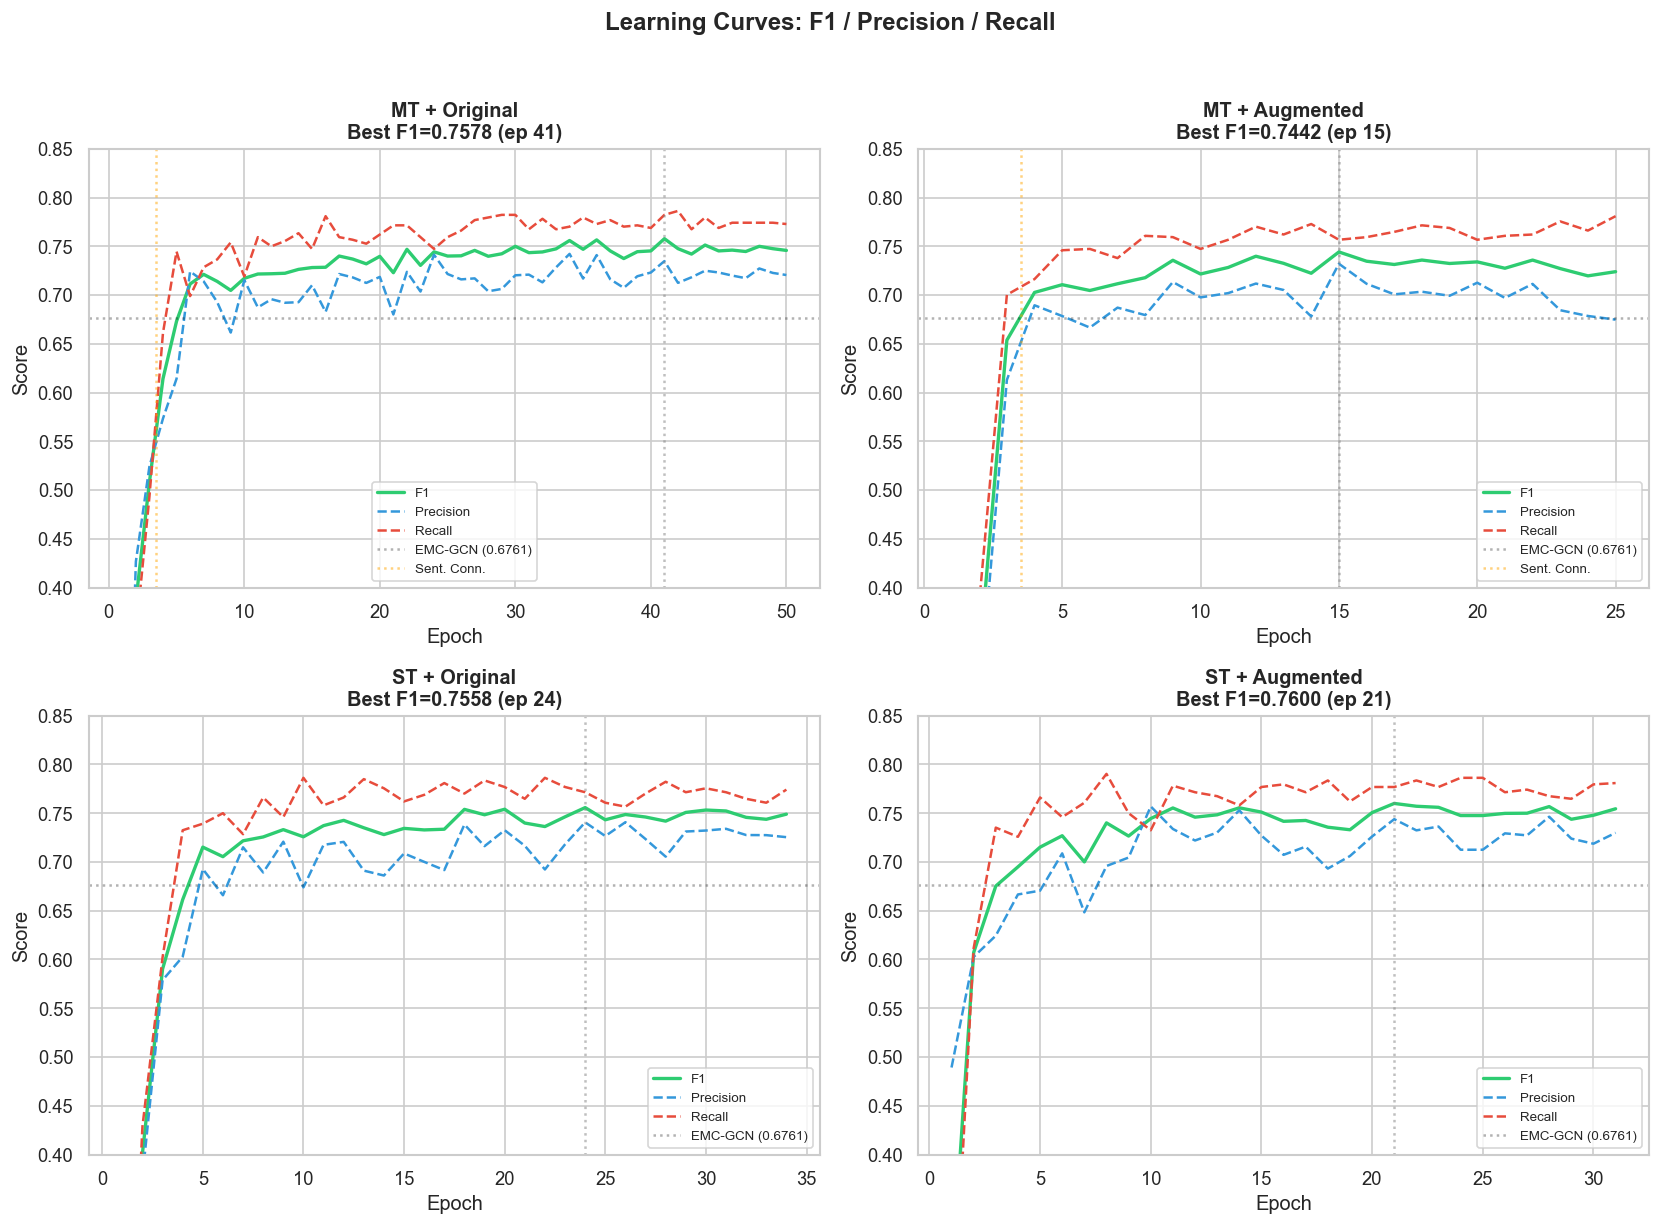

In [9]:
# Learning Curves: F1, Precision, Recall per run (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (run_name, r) in enumerate(all_results.items()):
    ax = axes[idx]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)

    ax.plot(epochs, h['val_f1'], label='F1', color='#2ecc71', linewidth=2)
    ax.plot(epochs, h['val_precision'], label='Precision', color='#3498db', linewidth=1.5, linestyle='--')
    ax.plot(epochs, h['val_recall'], label='Recall', color='#e74c3c', linewidth=1.5, linestyle='--')

    best_ep = r['best_epoch']
    ax.axvline(best_ep, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(PRIOR_RESEARCH_F1, color='black', linestyle=':', alpha=0.3, label=f'EMC-GCN ({PRIOR_RESEARCH_F1})')

    if r['model_type'] == 'multi_task':
        ax.axvline(PHASE1_EPOCHS + 0.5, color='orange', linestyle=':', alpha=0.5, label='Sent. Conn.')

    ax.set_title(f'{run_name}\nBest F1={r["best_f1"]:.4f} (ep {best_ep})', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend(fontsize=8)
    ax.set_ylim(0.4, 0.85)

plt.suptitle('Learning Curves: F1 / Precision / Recall', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

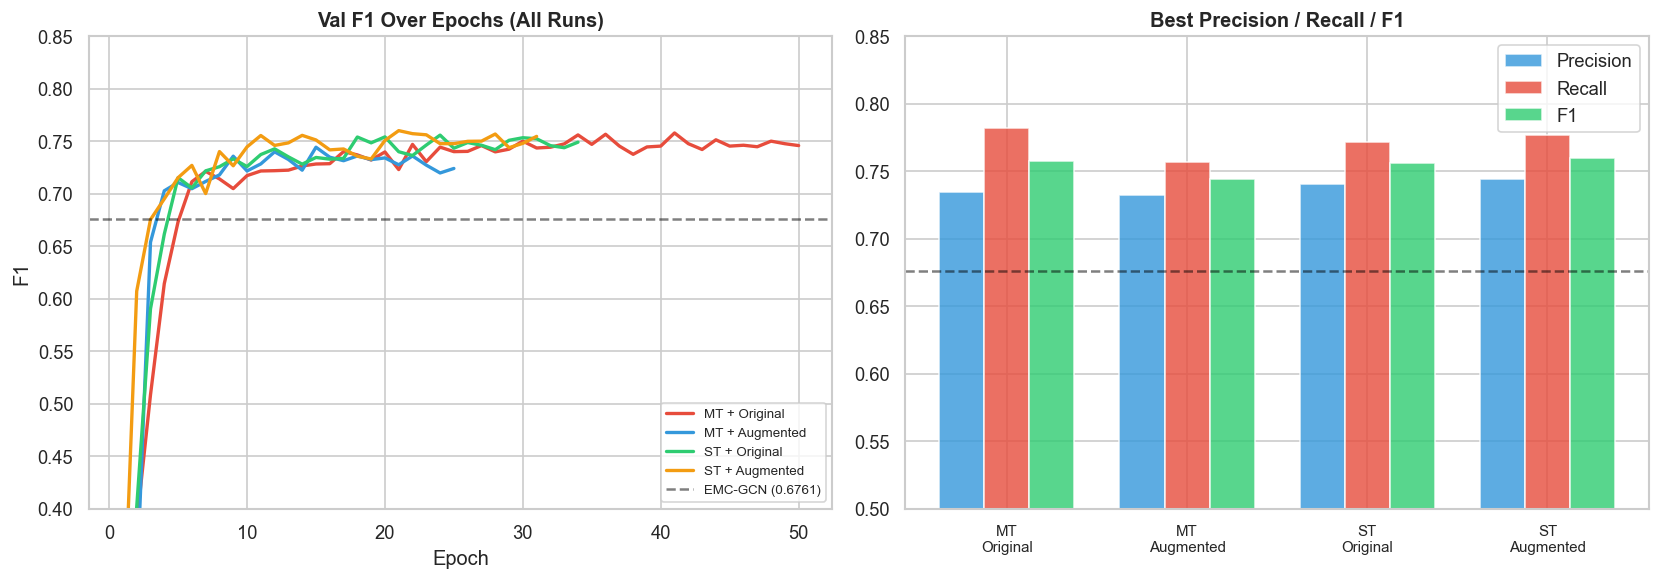

In [10]:
# Combined F1 comparison + Grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: F1 learning curves overlaid
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for idx, (run_name, r) in enumerate(all_results.items()):
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)
    axes[0].plot(epochs, h['val_f1'], label=run_name, color=colors[idx], linewidth=2)

axes[0].axhline(PRIOR_RESEARCH_F1, color='black', linestyle='--', alpha=0.5,
                label=f'EMC-GCN ({PRIOR_RESEARCH_F1})')
axes[0].set_title('Val F1 Over Epochs (All Runs)', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('F1')
axes[0].legend(fontsize=8)
axes[0].set_ylim(0.4, 0.85)

# Right: Grouped bar chart (Precision, Recall, F1)
run_names = list(all_results.keys())
f1s = [all_results[n]['best_f1'] for n in run_names]
precisions = [all_results[n]['history']['val_precision'][all_results[n]['best_epoch'] - 1] for n in run_names]
recalls = [all_results[n]['history']['val_recall'][all_results[n]['best_epoch'] - 1] for n in run_names]

x = np.arange(len(run_names))
width = 0.25
axes[1].bar(x - width, precisions, width, label='Precision', color='#3498db', alpha=0.8)
axes[1].bar(x, recalls, width, label='Recall', color='#e74c3c', alpha=0.8)
axes[1].bar(x + width, f1s, width, label='F1', color='#2ecc71', alpha=0.8)
axes[1].axhline(PRIOR_RESEARCH_F1, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Best Precision / Recall / F1', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([n.replace(' + ', '\n') for n in run_names], fontsize=9)
axes[1].legend()
axes[1].set_ylim(0.5, 0.85)

plt.tight_layout()
plt.show()

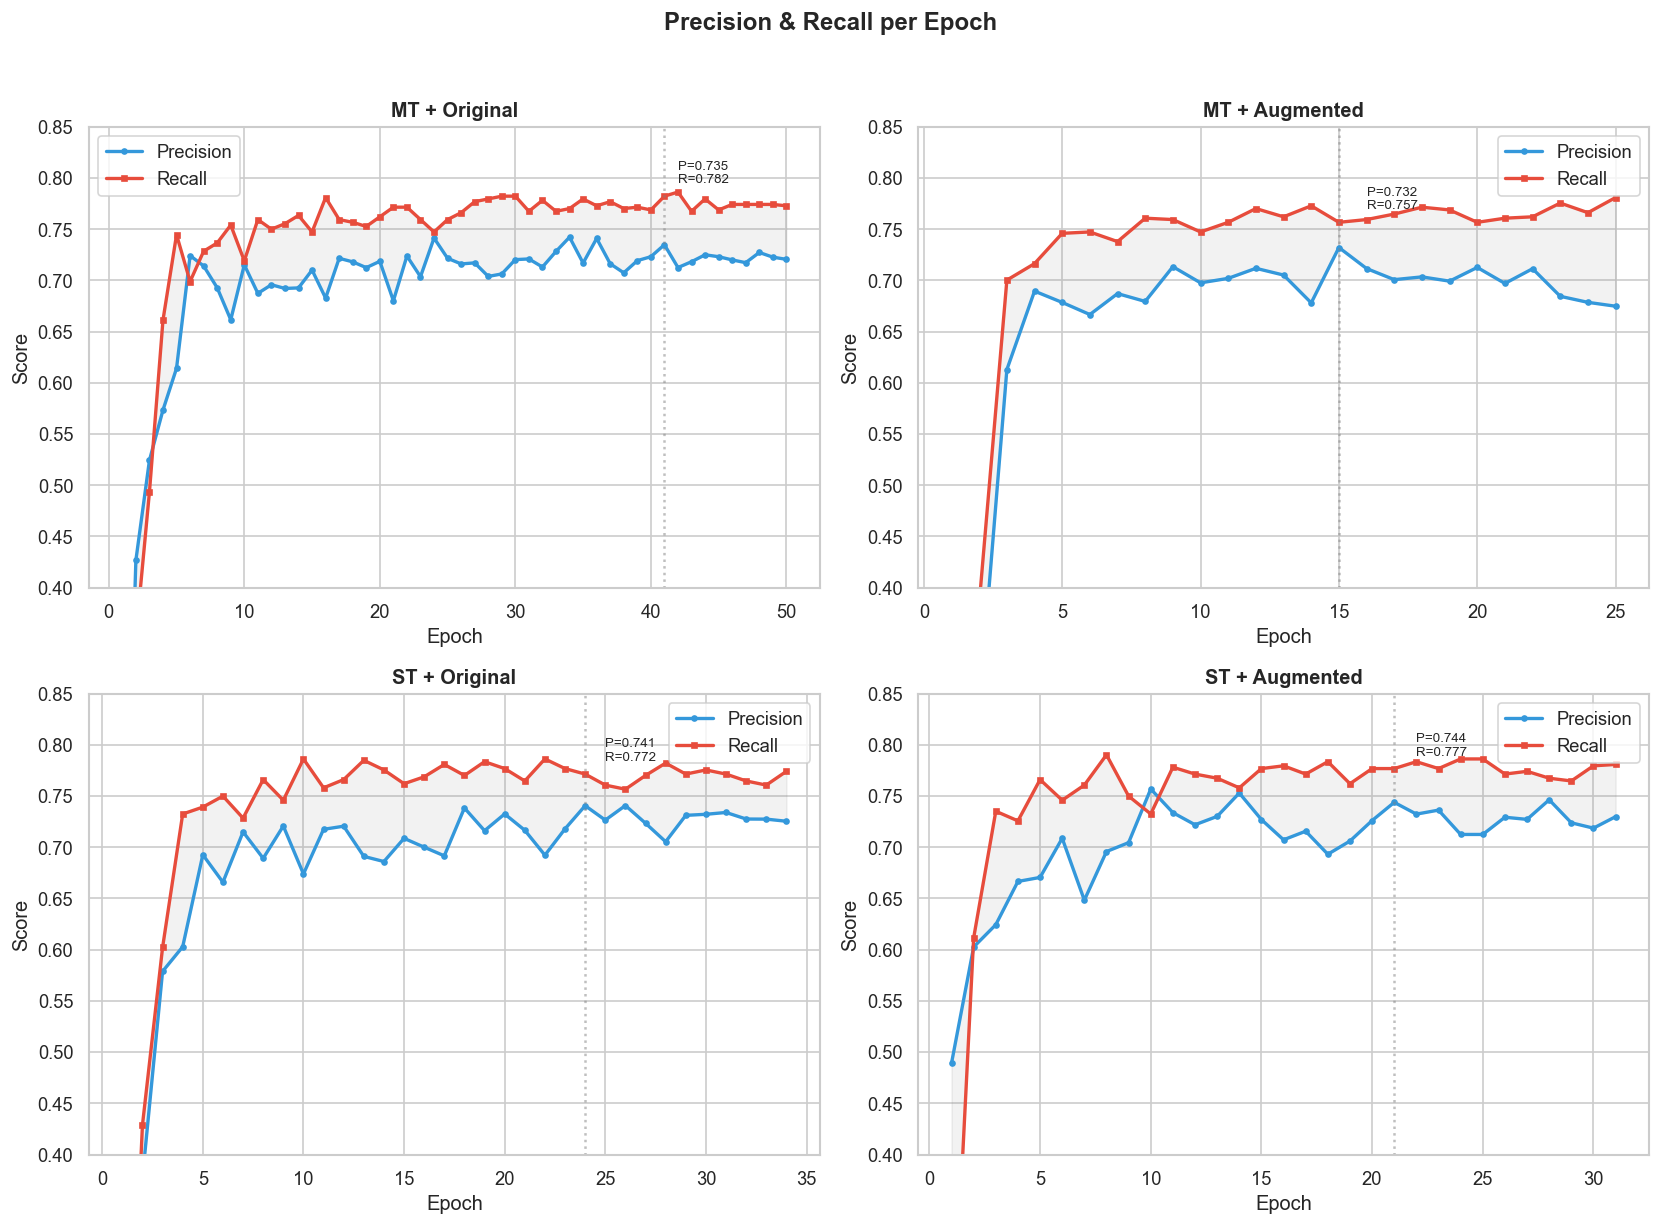

In [11]:
# Precision & Recall dedicated graphs (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (run_name, r) in enumerate(all_results.items()):
    ax = axes[idx]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)

    ax.plot(epochs, h['val_precision'], label='Precision', color='#3498db', linewidth=2, marker='o', markersize=3)
    ax.plot(epochs, h['val_recall'], label='Recall', color='#e74c3c', linewidth=2, marker='s', markersize=3)

    ax.fill_between(epochs, h['val_precision'], h['val_recall'], alpha=0.1, color='gray')

    best_ep = r['best_epoch']
    best_p = h['val_precision'][best_ep - 1]
    best_r = h['val_recall'][best_ep - 1]
    ax.axvline(best_ep, color='gray', linestyle=':', alpha=0.5)
    ax.annotate(f'P={best_p:.3f}\nR={best_r:.3f}', xy=(best_ep, max(best_p, best_r)),
                fontsize=8, ha='left', va='bottom',
                xytext=(best_ep + 1, max(best_p, best_r) + 0.01))

    ax.set_title(f'{run_name}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.legend()
    ax.set_ylim(0.4, 0.85)

plt.suptitle('Precision & Recall per Epoch', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 9. PER-CLASS BREAKDOWN

In [12]:
for run_name, r in all_results.items():
    print(f'\n{"="*60}')
    print(f'{run_name} (F1={r["best_f1"]:.4f}, Epoch {r["best_epoch"]})')
    print(f'{"="*60}')
    print(r['report'])


MT + Original (F1=0.7578, Epoch 41)
              precision    recall  f1-score   support

         NEG       0.61      0.64      0.62        83
         NEU       0.58      0.66      0.62       125
         POS       0.79      0.83      0.81       536

   micro avg       0.73      0.78      0.76       744
   macro avg       0.66      0.71      0.69       744
weighted avg       0.74      0.78      0.76       744


MT + Augmented (F1=0.7442, Epoch 15)
              precision    recall  f1-score   support

         NEG       0.53      0.55      0.54        83
         NEU       0.57      0.66      0.61       125
         POS       0.81      0.81      0.81       536

   micro avg       0.73      0.76      0.74       744
   macro avg       0.64      0.67      0.65       744
weighted avg       0.74      0.76      0.75       744


ST + Original (F1=0.7558, Epoch 24)
              precision    recall  f1-score   support

         NEG       0.65      0.66      0.66        83
         NEU     

### 10. MULTI-TASK SUBTASK LOSSES

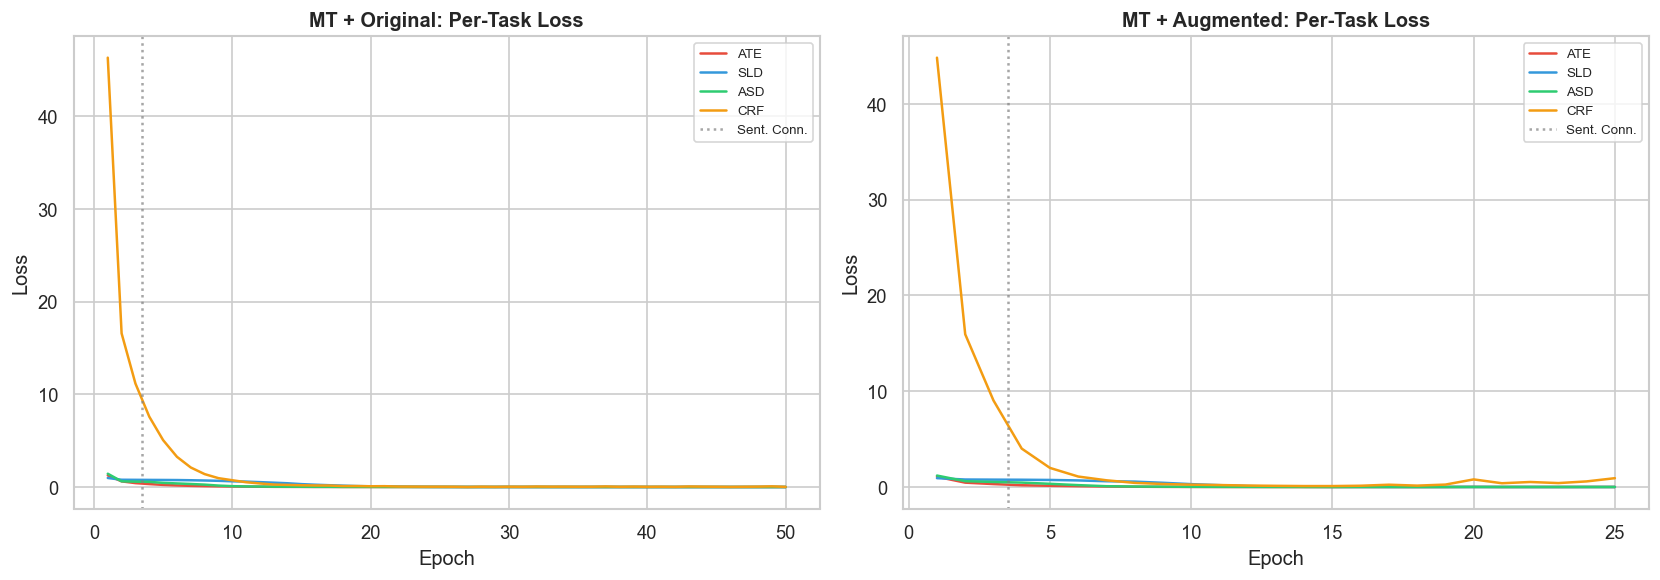

In [13]:
mt_runs = [(n, r) for n, r in all_results.items() if r['model_type'] == 'multi_task']

if len(mt_runs) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    task_colors = {'ate': '#e74c3c', 'sld': '#3498db', 'asd': '#2ecc71', 'crf': '#f39c12'}

    for idx, (run_name, r) in enumerate(mt_runs):
        ax = axes[idx]
        h = r['history']
        epochs = range(1, len(h['val_f1']) + 1)
        for task in ['ate', 'sld', 'asd', 'crf']:
            if f'loss_{task}' in h:
                ax.plot(epochs, h[f'loss_{task}'], label=task.upper(),
                        color=task_colors[task], linewidth=1.5)
        ax.axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Conn.')
        ax.set_title(f'{run_name}: Per-Task Loss', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()
elif len(mt_runs) == 1:
    run_name, r = mt_runs[0]
    h = r['history']
    epochs = range(1, len(h['val_f1']) + 1)
    fig, ax = plt.subplots(figsize=(8, 5))
    task_colors = {'ate': '#e74c3c', 'sld': '#3498db', 'asd': '#2ecc71', 'crf': '#f39c12'}
    for task in ['ate', 'sld', 'asd', 'crf']:
        if f'loss_{task}' in h:
            ax.plot(epochs, h[f'loss_{task}'], label=task.upper(),
                    color=task_colors[task], linewidth=1.5)
    ax.axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Conn.')
    ax.set_title(f'{run_name}: Per-Task Loss', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.tight_layout()
    plt.show()

### 11. KESIMPULAN

In [14]:
print('=' * 60)
print('KESIMPULAN EXTENDED TRAINING')
print('=' * 60)

# Sort by F1
sorted_runs = sorted(all_results.items(), key=lambda x: x[1]['best_f1'], reverse=True)

print('\nRanking F1:')
for i, (name, r) in enumerate(sorted_runs):
    best_idx = r['best_epoch'] - 1
    bp = r['history']['val_precision'][best_idx]
    br = r['history']['val_recall'][best_idx]
    print(f'  {i+1}. {name:<20s} F1={r["best_f1"]:.4f}  P={bp:.4f}  R={br:.4f}  (ep {r["best_epoch"]}/{r["epochs_trained"]})')

print(f'\nReferensi: EMC-GCN (penelitian sebelumnya) = {PRIOR_RESEARCH_F1}')
print(f'Semua konfigurasi vs EMC-GCN:')
for name, r in sorted_runs:
    diff = r['best_f1'] - PRIOR_RESEARCH_F1
    print(f'  {name:<20s}: +{diff:.4f}')

# Augmentation analysis
print(f'\nApakah augmentasi membantu?')
print(f'  Multi-Task:  {mt_orig_f1:.4f} -> {mt_aug_f1:.4f} ({mt_aug_f1 - mt_orig_f1:+.4f})')
print(f'  Single-Task: {st_orig_f1:.4f} -> {st_aug_f1:.4f} ({st_aug_f1 - st_orig_f1:+.4f})')

# Multi-task analysis
print(f'\nApakah multi-task lebih baik dari single-task?')
print(f'  Original:  MT={mt_orig_f1:.4f} vs ST={st_orig_f1:.4f} (diff={mt_orig_f1 - st_orig_f1:+.4f})')
print(f'  Augmented: MT={mt_aug_f1:.4f} vs ST={st_aug_f1:.4f} (diff={mt_aug_f1 - st_aug_f1:+.4f})')

# Precision vs Recall bias
print(f'\nPrecision vs Recall bias:')
for name, r in all_results.items():
    best_idx = r['best_epoch'] - 1
    bp = r['history']['val_precision'][best_idx]
    br = r['history']['val_recall'][best_idx]
    bias = 'Precision > Recall' if bp > br else 'Recall > Precision'
    print(f'  {name:<20s}: P={bp:.4f} R={br:.4f} ({bias})')

KESIMPULAN EXTENDED TRAINING

Ranking F1:
  1. ST + Augmented       F1=0.7600  P=0.7439  R=0.7769  (ep 21/31)
  2. MT + Original        F1=0.7578  P=0.7348  R=0.7823  (ep 41/50)
  3. ST + Original        F1=0.7558  P=0.7406  R=0.7715  (ep 24/34)
  4. MT + Augmented       F1=0.7442  P=0.7321  R=0.7567  (ep 15/25)

Referensi: EMC-GCN (penelitian sebelumnya) = 0.6761
Semua konfigurasi vs EMC-GCN:
  ST + Augmented      : +0.0839
  MT + Original       : +0.0817
  ST + Original       : +0.0797
  MT + Augmented      : +0.0681

Apakah augmentasi membantu?
  Multi-Task:  0.7578 -> 0.7442 (-0.0136)
  Single-Task: 0.7558 -> 0.7600 (+0.0043)

Apakah multi-task lebih baik dari single-task?
  Original:  MT=0.7578 vs ST=0.7558 (diff=+0.0021)
  Augmented: MT=0.7442 vs ST=0.7600 (diff=-0.0158)

Precision vs Recall bias:
  MT + Original       : P=0.7348 R=0.7823 (Recall > Precision)
  MT + Augmented      : P=0.7321 R=0.7567 (Recall > Precision)
  ST + Original       : P=0.7406 R=0.7715 (Recall > Precisi

### 12. SIMPAN HASIL

In [15]:
checkpoint = {
    'results': all_results,
    'config': {
        'model_name': MODEL_NAME,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE,
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'lr_bert': LR_BERT,
        'lr_head': LR_HEAD,
        'batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION,
        'lambda1': LAMBDA1,
        'lambda2': LAMBDA2,
        'phase1_epochs': PHASE1_EPOCHS,
        'seed': SEED,
    },
    'prior_research_f1': PRIOR_RESEARCH_F1,
    'runs': RUNS,
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_extended_training.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')

# Final summary
best_name = max(all_results, key=lambda k: all_results[k]['best_f1'])
print(f'\nBest: {best_name} (F1={all_results[best_name]["best_f1"]:.4f})')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_extended_training.pt
File size: 0.3 MB

Best: ST + Augmented (F1=0.7600)
